# Zajęcia 6

## Przetwarzanie danych rzeczywistych
## Fuzja zadań w jedną pracę
## Sprawozdanie z prac badawczych

### 1. Obsługa danych i podstawy implementacji obliczeń

   Wszystkie zadania wykonałem na pliku z internetu. Pochodzi on z Wikipedii a przedstawia dane oraz statystyki rzek przepływających przez Białoruś. Zaimportujmy potrzebne biblioteki oraz odczytajmy sam plik.

In [26]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

URL = "https://en.wikipedia.org/wiki/List_of_rivers_of_Belarus"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df = pd.read_html(str(tab))[0]
df


,Name,"Total, km","In Belarus, km"
0,Dnieper River,2145,690
1,Western Dvina,1020,328
2,Neman River,937,459
3,Bug River,831,169
4,Pripyat River,761,495
5,Sozh River,648,493
6,Berezina River,613,613
7,Vilija,510,276
8,Ptsich,421,421
9,Shchara,325,325


Przedstawmy powyższe dane na wykresie. Najlepszym do tego celu będzie wykres kolumnowy, który na osi x będzie zawierał nazwy rzek, natomiast na osi y stosunek długości danej rzeki w kraju do jej długości całkowitej w procentach.

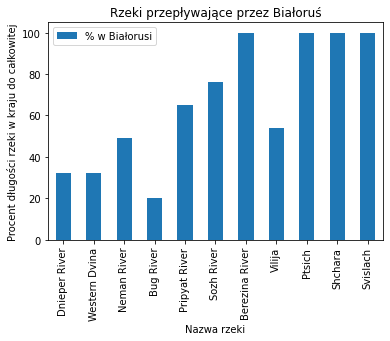

In [27]:
import matplotlib.pyplot as plt

df['% w Białorusi'] = df['In Belarus, km'] / df['Total, km'] * 100

riversPlot = df.plot(x='Name', y='% w Białorusi', kind='bar', title='Rzeki przepływające przez Białoruś')
plt.xticks(rotation=90)
riversPlot.set_xlabel('Nazwa rzeki')
riversPlot.set_ylabel('Procent długości rzeki w kraju do całkowitej')
plt.show()


Mając taki wykres łatwo można stwierdzić, które rzeki mają ponad 50% swojej długości w kraju. Nie potrzeba dużej modyfikacji by to zwizualizować.

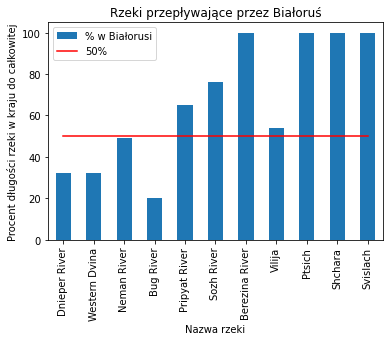

In [28]:
line50 = []
dataSize = df['% w Białorusi'].size
PERCENT50 = 50

for i in range(0, dataSize):
    line50.append(PERCENT50)

ax = df.plot(x = "Name", y = "% w Białorusi", kind = "bar", title = "Rzeki przepływające przez Białoruś")
ax.set_xlabel('Nazwa rzeki')
ax.set_ylabel('Procent długości rzeki w kraju do całkowitej')

bx = pd.DataFrame(line50, columns = ['50%'])
bx.plot(ax=ax, color='#FF0000')
plt.xticks(ax.get_xticks(), rotation = 90)
plt.show()


### 2. Dopasowanie modelu do danych rzeczywistych

Żeby pracować na modelu należy najpierw go utworzyć, a żeby go utworzyć musimy wyodrębnić dwa zbiory z naszych danych. Potrzebna jest nam zależność, dla ktorej program wyznaczy najlepszy model. Niech zbiorem X będzie "Długość całkowita", natomiast zbiorem Y "Długość w kraju".

In [29]:
X = df['Total, km'].values
Y = df['In Belarus, km'].values

print('Zbiór X - Długości całkowite rzek: %s' % X)
print('Zbiór Y - Długości rzek w kraju:   %s' % Y)


Zbiór X - Długości całkowite rzek: [2145 1020  937  831  761  648  613  510  421  325  297]
Zbiór Y - Długości rzek w kraju:   [690 328 459 169 495 493 613 276 421 325 297]


Zanim przejdziemy do budowy modelu zobaczmy jak nasze dane wyglądają na wykresie.

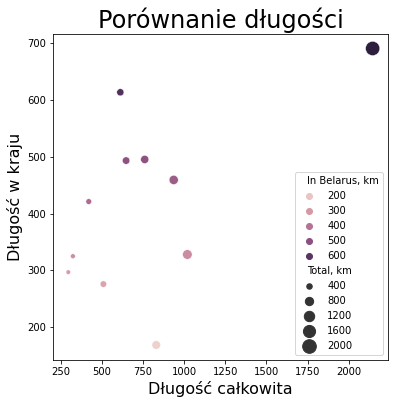

In [30]:
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(
    x = 'Total, km',
    y = 'In Belarus, km',
    data = df,
    hue = 'In Belarus, km',
    size = 'Total, km',
    sizes = (20, 200),
    legend = 'brief'
)
plt.xlabel("Długość całkowita", size=16)
plt.ylabel("Długość w kraju", size=16)
plt.title("Porównanie długości", size=24)
plt.show()


#### Metoda prób i błędów

 Metoda prób i błędów pozwala wyznaczyć przybliżony model liniowy. Nie jest on idealny, ponieważ jak widzimy błąd średniokwadratowy jest bardzo duży. Do policzenia błędu korzystam z następującego wzoru:

$$e_i=y_i-\overline{y_i}.$$

\begin{equation}
Q(a,b) = \frac{1}{N}\sum_{i=1}^Ne_i^2 \ ,
\tag{2}
\end{equation}

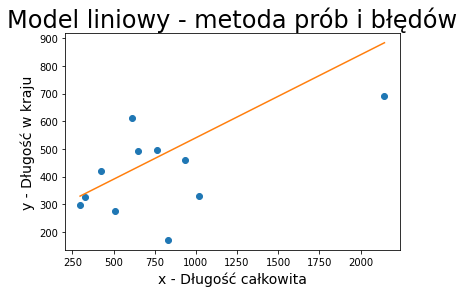

Parametr a wynosi 0.3
Parametr b wynosi 240
Błąd przybliżenia wynosi: 22653.47


In [38]:
def model (parametry, x):
    a, b = parametry
    return a * x + b

# dobieramy liczby tak żeby 'pasowało'
a_est, b_est = 0.3, 240

# liczymy błąd
def count_error(a_est, b_est):
    dataSize = X.size
    error = 0
    for i in range(0, dataSize):
        error = error + ( ( Y[i] - ( a_est * X[i] + b_est ) ) ) ** 2
    return error

# rysujemy wykres
X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [a_est, b_est], x = X_test)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'tab:orange')
plt.xlabel('x - Długość całkowita', fontsize = 14)
plt.ylabel('y - Długość w kraju', fontsize = 14)
plt.title('Model liniowy - metoda prób i błędów', size = 24)
plt.show()

# wyświetlamy błąd
print('Parametr a wynosi %s' % round(a_est, 4))
print('Parametr b wynosi %s' % round(b_est,2))
print('Błąd przybliżenia wynosi: %s' % str(round(count_error(a_est, b_est) / dataSize, 2)) )


#### Metoda analityczna

Ta metoda jest skuteczniejsza, jednak nie aż tak jak metody biblioteczne języka python. Dlaczego? Ponieważ liczę tutaj po kolei każdy element sumy w pętli for, biblioteki pythona robią to znacznie efektywniej, dzięki czemu są szybsze i dokładniejsze. Korzystam tutaj z metody najmniejszych kwadratów poznanej na wykładzie, czyli z następujących wzorów:

$$a = \frac{\left( \sum^{n}_{i = 1} x_i y_i \right) - n \cdot \overline{x} \cdot \overline{y}}{\left( \sum^{n}_{i = 1} x_{i}^2 \right) - n \cdot \overline{x}^2}$$

$$b = \overline{y} - a \cdot \overline{x}$$

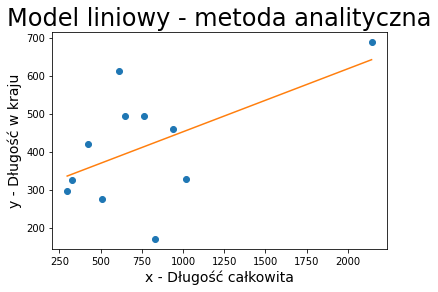

Parametr a estymowany metodą najmniejszych kwadratów wynosi 0.1659
Parametr b estymowany metodą najmniejszych kwadratów wynosi 286.75
Błąd przybliżenia wynosi: 15104.65


In [39]:
xAvr = X.mean()
yAvr = Y.mean()
DATASIZE = X.size

a_est = 0
b_est = 0

# liczymy a
# licznik
up = 1
for i in range(0, DATASIZE):
    up = up + (X[i] * Y[i])
up = up - (DATASIZE * xAvr * yAvr)

# mianownik
down = 1
for i in range(0, DATASIZE):
    down = down + (X[i] ** 2)
down = down - (DATASIZE * (xAvr ** 2))

# wynik
a_est = up / down

# liczymy b
b_est = yAvr - (a_est * xAvr)

# rysujemy wykres
X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [a_est, b_est], x = X_test)

plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'tab:orange')
plt.xlabel('x - Długość całkowita', fontsize = 14)
plt.ylabel('y - Długość w kraju', fontsize = 14)
plt.title('Model liniowy - metoda analityczna', size = 24)
plt.show()

# wyświetlamy wyliczone wartości
print('Parametr a estymowany metodą najmniejszych kwadratów wynosi %s' % round(a_est, 4))
print('Parametr b estymowany metodą najmniejszych kwadratów wynosi %s' % round(b_est,2))
print('Błąd przybliżenia wynosi: %s' % str(round(count_error(a_est, b_est) / DATASIZE, 2)) )

Jak łatwo zauważyć metoda analityczna daje znacznie lepszy wynik od metody prób i błędów, ponieważ błąd jest dużo mniejszy.

#### Model i testy

Budowa oraz ćwiczenie modelu wymagają utowrzenia dodatkowych zbiorów testowych. Musimy zatem podzielić nasz zbiór X na zbiór treningowy: X_train oraz zbiór testowy X_test. Analogicznie postępujemy dla zbioru Y. Mamy na wykresie narysowane dwa modele: liniowy oraz uogólniony liniowy. Ponadto zaznaczone jest które rzeki zostały wzięte do treningu, a które do testów.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df['Total, km'].values
Y = df['In Belarus, km'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

def showPlot(percentTrain, percentTest):
    # =========  Model liniowy =========
    from sklearn.linear_model import LinearRegression
    model_lin = LinearRegression()
    model_lin.fit(X_train.reshape(-1,1), Y_train)
    print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
    MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
    print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

    # ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
    from sklearn.preprocessing import PolynomialFeatures
    model_GLM = LinearRegression()
    gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
    model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
              Y_train)
    print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
    MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
    print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

    # Predykcje wszystkich modeli dla całego zakreso osi X
    os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
    y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
    y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

    # Wizualizacja
    plt.figure(figsize=(10,7))
    plt.scatter(X_train, Y_train, label='dane treningowe: %s' % str(percentTrain * 100), alpha=0.7)
    plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące: %s' % str(percentTest * 100))
    plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
    plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
    plt.xlabel('Długość całkowita', fontsize=14)
    plt.ylabel('Długość w kraju', fontsize=14)
    plt.title('Model liniowy - biblioteki Python', size=24)
    plt.legend(fontsize=12, shadow=True, loc='lower right')
    plt.ylim([Y.min()-0.1, Y.max()+0.5])
    plt.show()
    

##### Dane treningowe 80% : Dane testujące 20%

Parametry modelu liniowego: [0.16136], 313.51411
Błąd średniokwadratowy modelu liniowego: 9.45e+03

Parametry modelu GLM: [ 0.00e+00 -2.57e-01  2.00e-04], 515.89086
Błąd średniokwadratowy modelu GLM: 1.59e+04



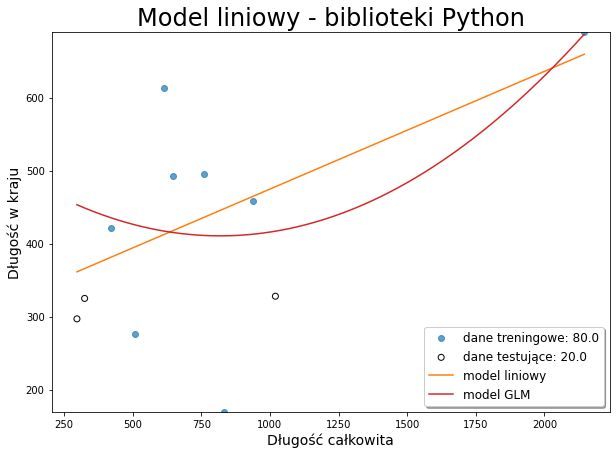

In [45]:
showPlot(0.8, 0.2)


Co by się stało gdybyśmy zwiększyli ilość danych do testów? Czy zmienił by się kształt któregoś z wykresów? Sprawdźmy to doświadczalnie: za pierwszym razem weźmy 30% danych do testów a za drugim 50%.

##### Dane treningowe 70% : Dane testujące 30%

Parametry modelu liniowego: [0.1552], 289.94234
Błąd średniokwadratowy modelu liniowego: 2.47e+03

Parametry modelu GLM: [ 0.00e+00 -7.07e-01  3.00e-04], 698.93589
Błąd średniokwadratowy modelu GLM: 3e+04



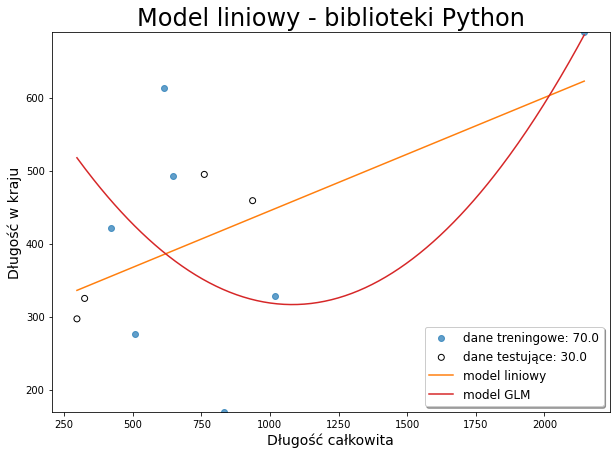

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
showPlot(0.7, 0.3)


#### Dane treningowe 50% : Dane testujące 50%

Parametry modelu liniowego: [-0.03814], 367.35696
Błąd średniokwadratowy modelu liniowego: 4.86e+04

Parametry modelu GLM: [ 0.0000e+00 -1.1383e+00  8.0000e-04], 665.40719
Błąd średniokwadratowy modelu GLM: 3.39e+05



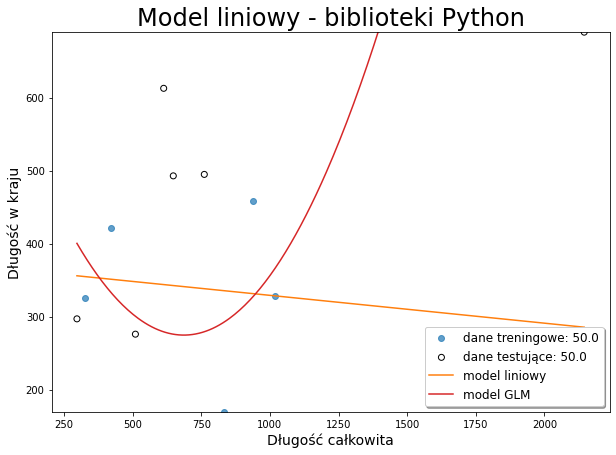

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
showPlot(0.5, 0.5)